# Description

Training and hypertuning NODE for tabular data

Referenced from the blog post about NODE and CatBoost on [Follow the Data](https://followthedata.wordpress.com/modelling-tabular-data-with-catboost-and-node).

In [1]:
import math
import os
import time

##Clone the NODE repository.

In [2]:
!git clone https://github.com/Qwicen/node.git

Cloning into 'node'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 8), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [3]:
os.chdir('node')

## Install the dependencies.

In [4]:
!pip install -r requirements.txt

     | 7.6MB 13.9MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55.4MB 53kB/s 
     |████████████████████████████████| 16.6MB 216kB/s 
     |████████████████████████████████| 122kB 60.7MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
  Created wheel for qhoptim: filename=qhoptim-1.1.0-cp37-none-any.whl size=20327 sha256=4504d284b92d5dac0981232d60f2a5406ee4aef91ab1092b2013cce139a57277
  Stored in directory: /tmp/pip-ephem-wheel-cache-px8mmco7/wheels/63/53/2b/3b721f6feacd39063f6300e890b7cf633910a33e7b996edbd3
Successfully built qhoptim
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


# New Section

## Load, split and preprocess the data.

Owing to the time it takes to train a NODE model, we will not use k-fold cross validation as we did in the [CatBoost/logistic regression notebook](https://) but simply use a train/test split.


In [5]:
from category_encoders import LeaveOneOutEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://docs.google.com/uc?id=10eFO2rVlsQBUffn0b7UCAp28n0mkLCy7&export=download')
labels = df.pop('<=50K')

X_train, X_val, y_train, y_val = train_test_split(df, labels, test_size=0.2)
 
class_to_int = {c: i for i, c in enumerate(y_train.unique())}                                                                                                               
y_train_int = [class_to_int[v] for v in y_train]                                                                                                                            
y_val_int = [class_to_int[v] for v in y_val] 

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  

cat_encoder = LeaveOneOutEncoder()
cat_encoder.fit(X_train[cat_features], y_train_int)
X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
X_val[cat_features] = cat_encoder.transform(X_val[cat_features])

# Node is going to want to have the values as float32 at some points
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
y_train = np.array(y_train_int)
y_val = np.array(y_val_int)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Now we have a fully numeric dataset, and we can start using the NODE functionality.

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qhoptim.pyt import QHAdam
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# We access the NODE functionality through the lib/ subfolder.
import lib 
%matplotlib inline

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


Initialize a NODE model. There are some parameters here to be aware of:

- layer_dim (how many "trees" should be used in each layer)
- num_layers (how many layers, i.e. how many stacked tree ensembles)
- depth (how many levels should each tree have)

I am not sure what the significance of 'flatten_output' is. In the example notebook, they set the tree_dim to no_classes+1, but here I do not add 1. The 'choice_function' and 'bin_function' parameters should be left as is. 

In [8]:
num_features = X_train.shape[1]
num_classes = len(set(y_train))
ts = math.floor(time.time())
experiment_name = f'node_adult_{ts}'

In [84]:
model = nn.Sequential(
    lib.DenseBlock(num_features,
                   layer_dim=128,
                   num_layers=8,
                   tree_dim=num_classes,
                   flatten_output=False,
                   depth=6,
                   choice_function=lib.entmax15,
                   bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train[:2000], device=device))
    # trigger data-aware init

## Initialize a Trainer object.

This is a class that the NODE authors wrote to help take care of the training process. You may prefer to write your own training loop in Pytorch instead.

In [86]:
trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name+'_extra_2',
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)

## Define parameters for the training loop.

Let's use 2500 batches as the early stopping criterion.

In [87]:
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 2500
report_frequency = 50

In [88]:
X_train.shape[0]

26048

This training loop is taken from the example notebook.

In [89]:
train_acc, test_acc = [], []

for batch in lib.iterate_minibatches(X_train,
                                     y_train,
                                     batch_size=512, 
                                     shuffle=True,
                                     epochs=1000):
    metrics = trainer.train_on_batch(*batch, device=device)
    



    if trainer.step % report_frequency == 0:
        print(trainer.step)
        loss_history.append(metrics['loss'])

        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            X_train,
            y_train,
            device=device,
            batch_size=128)
        
        train_acc.append(err)
        err = trainer.evaluate_classification_error(
            X_val,
            y_val,
            device=device,
            batch_size=128)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        '''
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        '''

        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvement for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

50
Saved logs/node_adult_1618788365_extra_2/checkpoint_temp_50.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_avg.pth
Saved logs/node_adult_1618788365_extra_2/checkpoint_best.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_temp_50.pth
Loss 0.56056
Val Error Rate: 0.24704
100
Saved logs/node_adult_1618788365_extra_2/checkpoint_temp_100.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_avg.pth
Saved logs/node_adult_1618788365_extra_2/checkpoint_best.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_temp_100.pth
Loss 0.52456
Val Error Rate: 0.24474
150
Saved logs/node_adult_1618788365_extra_2/checkpoint_temp_150.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_avg.pth
Saved logs/node_adult_1618788365_extra_2/checkpoint_best.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint_temp_150.pth
Loss 0.47018
Val Error Rate: 0.23998
200
Saved logs/node_adult_1618788365_extra_2/checkpoint_temp_200.pth
Loaded logs/node_adult_1618788365_extra_2/checkpoint

In [93]:
train_acc = pd.Series(train_acc, index=[i for i in range(89)])
val_acc = pd.Series(err_history, index=[i for i in range(89)])

train_loss = pd.Series(loss_history, index=[i for i in range(89)])

In [95]:
1 - trainer.evaluate_classification_error(
            X_val,
            y_val,
            device=device,
)

0.8507600184246891

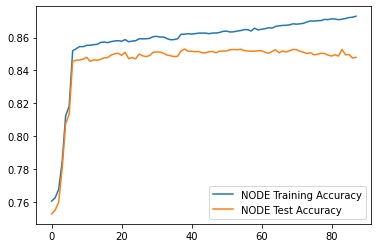

In [96]:
df = pd.concat([train_acc, val_acc], axis=1, keys=['NODE Training Accuracy', 'NODE Test Accuracy'])
df = df.reindex(range(df.index[-1]))
df = 1-df
df.to_csv('node.csv')
df.plot()


##Hyperparameter optimization with hyperopt



In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import fmin, hp, STATUS_OK, tpe

In [ ]:
def opt_fn(search_space):
  print(search_space)
  best_val_err = 1.0
  best_step = 0
  early_stopping_rounds = 2500
  report_frequency = 1000
  experiment_name = 'debug' # this bypasses some code that will be executed each time otherwise
  
  model = nn.Sequential(
      lib.DenseBlock(num_features,
                     layer_dim=int(search_space['layer_dim']),
                     num_layers=int(search_space['num_layers']),
                     tree_dim=num_classes,
                     flatten_output=False,
                     depth=int(search_space['depth']),
                     choice_function=lib.entmax15,
                     bin_function=lib.entmoid15),
      lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
    ).to(device)

  with torch.no_grad():
    res = model(torch.as_tensor(X_train[:2000], device=device))
    # trigger data-aware init

  trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
  )

  for batch in lib.iterate_minibatches(X_train,
                                     y_train,
                                     batch_size=512, 
                                     shuffle=True,
                                     epochs=float('inf')):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    

    if trainer.step % report_frequency == 0:
          err = trainer.evaluate_classification_error(
              X_val,
              y_val,
              device=device,
              batch_size=64)
        
          if err < best_val_err:
              best_val_err = err
              best_step = trainer.step

          print("Loss %.5f" % (metrics['loss']))
          print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
          opt_metric = best_val_err
          break
          
  return {'loss': opt_metric, 'status': STATUS_OK}

In [ ]:
search_space = {'layer_dim': hp.quniform('layer_dim', 100, 1200, 100),
                'num_layers': hp.quniform('num_layers', 1, 4, 1),
                'depth': hp.quniform('depth', 2, 7, 1)
    }

In [ ]:
best = fmin(fn=opt_fn, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=100)

{'depth': 5.0, 'layer_dim': 400.0, 'num_layers': 1.0}
Loss 0.49489
Val Error Rate: 0.19752
Loss 0.37428
Val Error Rate: 0.18474
Loss 0.36075
Val Error Rate: 0.18315
Loss 0.34080
Val Error Rate: 0.14359
Loss 0.32484
Val Error Rate: 0.14384
Loss 0.33885
Val Error Rate: 0.14310
Loss 0.33447
Val Error Rate: 0.14237
Loss 0.32657
Val Error Rate: 0.14175
Loss 0.28023
Val Error Rate: 0.14040
Loss 0.30521
Val Error Rate: 0.13905
Loss 0.29295
Val Error Rate: 0.14040
Loss 0.31161
Val Error Rate: 0.14040
{'depth': 3.0, 'layer_dim': 400.0, 'num_layers': 3.0}
Loss 0.34179
Val Error Rate: 0.13856
Loss 0.29840
Val Error Rate: 0.13192
Loss 0.32886
Val Error Rate: 0.13266
Loss 0.30286
Val Error Rate: 0.13070
Loss 0.27480
Val Error Rate: 0.13291
Loss 0.27905
Val Error Rate: 0.13045
Loss 0.27075
Val Error Rate: 0.12947
Loss 0.20901
Val Error Rate: 0.12947
Loss 0.26313
Val Error Rate: 0.13045
{'depth': 2.0, 'layer_dim': 500.0, 'num_layers': 1.0}
Loss 0.53569
Val Error Rate: 0.24076
Loss 0.45835
Val Error R

KeyboardInterrupt: ignored